# Imported Data Handling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(skip_top = 200, num_words=4000)

word_index = tf.keras.datasets.imdb.get_word_index()
index2word = dict((i + 3, word) for (word, i) in word_index.items())
index2word[0] = '[pad]'
index2word[1] = '[bos]'
index2word[2] = '[oov]'
x_train = np.array([' '.join([index2word[idx] for idx in text]) for text in x_train])
x_test = np.array([' '.join([index2word[idx] for idx in text]) for text in x_test])

In [3]:
vocabulary = list()
for text in x_train:
  tokens = text.split()
  vocabulary.extend(tokens)

vocabulary = set(vocabulary)
vocabulary =  np.array(list(vocabulary))
print(len(vocabulary))


3801


In [ ]:
from tqdm import tqdm

x_train_binary = list()
x_test_binary = list()

for text in tqdm(x_train):
  tokens = text.split()
  binary_vector = list()
  for vocab_token in vocabulary:
    if vocab_token in tokens:
      binary_vector.append(1)
    else:
      binary_vector.append(0)
  x_train_binary.append(binary_vector)

x_train_binary = np.array(x_train_binary)

for text in tqdm(x_test):
  tokens = text.split()
  binary_vector = list()
  for vocab_token in vocabulary:
    if vocab_token in tokens:
      binary_vector.append(1)
    else:
      binary_vector.append(0)
  x_test_binary.append(binary_vector)

x_test_binary = np.array(x_test_binary)


# Bernoulli Naive Bayes with Laplace


In [17]:
from mpmath import mp

#mp.dps = 50

Naive Bayes Implementation

In [18]:
class NaiveBayes:
  def __init__(self, laplace = 1.0):
    self.laplace = laplace
    self.class_probs = np.zeros(2) #P(C = 0)[0] KAI P(C = 1)[1]
    self.word_probs = list() #index 0 - Vocabulary
                             #index 1 - Lista forwn kathe lekshs pou emfanizetai thetika
                             #index 2 - Lista forwn kathe lekshs pou emfanizetai arnhtika

  def fit(self, x_train, y_train):
    print(len(x_train))
    num_of_reviews = len(x_train) #25.000
    num_of_words = len(x_train[0]) #4.000

    #compute C possibilities
    #P(C = 1) = synolo thetikwn reviews / synolo reviews
    #P(C = 0) = synolo arnhtikwn reviews / synolo reviews

    #P(c = c)
    self.class_probs[1] = np.sum(y_train) / len(y_train) #P(c = 1) = athrisma twn 1 / megethos listas
    self.class_probs[0] = 1 - self.class_probs[1] #P(c = 0) = 1 - P(c = 1)

    #Compute X/C possibilities
    #ftiaxnei sublist tou x_train_binary pou periexei mono ta thetika kai allo ena me mono ta arnhtika reviews
    positive_reviews = x_train[y_train == 1]
    negative_reviews = x_train[y_train == 0]

    #ftiaxnei sublists pou periexoun thn emfanish twn thetikwn kai twn arnhtikwn leksewn
    sum_each_positivewords = np.sum(positive_reviews, axis=0)
    sum_each_negativewords = np.sum(negative_reviews, axis=0)

    #synolikes thetikes kai arnhtikes lekseis pou xrhsimopoithikan
    sum_pos = (np.sum(sum_each_positivewords))
    sum_neg = (np.sum(sum_each_negativewords))

    self.word_probs.append(vocabulary)
    self.word_probs.append(sum_each_positivewords)
    self.word_probs.append(sum_each_negativewords)

    #cast apo np.int se np.float gia na ginoun swsta oi prakseis apo katw
    self.word_probs[1] = self.word_probs[1].astype(np.float64)
    self.word_probs[2] = self.word_probs[2].astype(np.float64)

    #P(xi | c = c): (emfanish lekshs X + 1 / synolo leksewn se C = C + k)
    for i in range(len(self.word_probs[0])):
      self.word_probs[1][i] = (self.word_probs[1][i] + self.laplace) / (sum_pos + self.laplace * len(self.word_probs[0]))
      self.word_probs[2][i] = (self.word_probs[2][i] + self.laplace) / (sum_neg + self.laplace * len(self.word_probs[0]))


  def predict(self, X):
    counter = 1
    y_predict = np.zeros(len(X))
    pos_prob = mp.mpf(self.class_probs[1])
    neg_prob = mp.mpf(self.class_probs[0])
    for i in range(len(X)): #(0 - 24999)
      pos_prob = mp.mpf(self.class_probs[1])
      neg_prob = mp.mpf(self.class_probs[0])
      for j in range(len(X[0])):#(0 - 3998)
        if X[i][j] == 1:

          pos_prob = pos_prob * mp.mpf(self.word_probs[1][j])
          neg_prob = neg_prob * mp.mpf(self.word_probs[2][j])

      if pos_prob > neg_prob:
        #print("Review "+ str(i) + " is POSITIVE")
        y_predict[i] = 1
      elif pos_prob < neg_prob:
        #print("Review "+ str(i) + " is NEGATIVE")
        y_predict[i] = 0
      else:
        print("REVIEW NULLIFIED")

    return y_predict.astype(int)



Classification Report

In [ ]:
from sklearn.metrics import classification_report


classifier = NaiveBayes(laplace = 1.0)
classifier.fit(x_train_binary, y_train)

print(classification_report(y_train, classifier.predict(x_train_binary),
                            zero_division=1))
print(classification_report(y_test, classifier.predict(x_test_binary),
                            zero_division=1))


Data Split for Diagrams

In [20]:
from sklearn.model_selection import train_test_split
# split rest of the train data into train and dev
x_trainbinary_copy, x_dev_binary, y_traincopy, y_dev = train_test_split(x_train_binary, y_train,
                                                                test_size=0.3)
print(x_train_binary.shape)
print(x_trainbinary_copy.shape)

(25000, 301)
(17500, 301)


Learning Curve

In [ ]:
from sklearn.metrics import accuracy_score
def custom_learning_curve(x_train, y_train,
                          x_val, y_val, x_test, y_test,
                          n_splits):

  split_size = int(len(x_train) / n_splits)
  x_splits = np.split(x_train, n_splits) # must be equal division
  y_splits = np.split(y_train, n_splits)
  train_accuracies = list()
  val_accuracies = list()
  test_accuracies = list()
  curr_x = x_splits[0]
  print(curr_x.shape)
  curr_y = y_splits[0]
  print(curr_y.shape)
  classifier = NaiveBayes()
  classifier.fit(curr_x, curr_y)
  train_accuracies.append(accuracy_score(curr_y,
                                         classifier.predict(curr_x)))

  val_accuracies.append(accuracy_score(y_val, classifier.predict(x_val)))
  test_accuracies.append(accuracy_score(y_test, classifier.predict(x_test)))

  for i in range(1, len(x_splits)):
    classifier = NaiveBayes()
    curr_x = np.concatenate((curr_x, x_splits[i]), axis=0)
    print(curr_x.shape)
    curr_y = np.concatenate((curr_y, y_splits[i]), axis=0)
    print(curr_y.shape)
    classifier.fit(curr_x, curr_y)

    train_accuracies.append(accuracy_score(curr_y,
                                           classifier.predict(curr_x)))

    val_accuracies.append(accuracy_score(y_val, classifier.predict(x_val)))

    test_accuracies.append(accuracy_score(y_test, classifier.predict(x_test)))

  plt.plot(list(range(split_size, len(x_train) + split_size,
                      split_size)), train_accuracies, 'o-', color="b",
             label="Training accuracy")
  plt.plot(list(range(split_size, len(x_train) + split_size,
                      split_size)), val_accuracies, 'o-', color="green",
           label="Validation accuracy")
  plt.plot(list(range(split_size, len(x_train) + split_size,
                      split_size)), test_accuracies, 'o-', color="red",
           label="Testing accuracy")
  plt.legend(loc="lower right")
  plt.show()

custom_learning_curve(x_train=x_trainbinary_copy , y_train=y_traincopy,
                      x_val=x_dev_binary, y_val=y_dev, x_test=x_test_binary,
                      y_test=y_test, n_splits=10)

# SkLearn Bernoulli Naive Bayes

Classification Report

In [ ]:
from sklearn.naive_bayes import BernoulliNB
bernoulli_nb = BernoulliNB(alpha = 1.0)
bernoulli_nb.fit(x_train_binary, y_train)
print(classification_report(y_train, bernoulli_nb.predict(x_train_binary),
                            zero_division=1))
print(classification_report(y_test, bernoulli_nb.predict(x_test_binary),
                            zero_division=1))



              precision    recall  f1-score   support

           0       0.86      0.87      0.86     12500
           1       0.87      0.85      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000

              precision    recall  f1-score   support

           0       0.83      0.86      0.84     12500
           1       0.86      0.82      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



Learning Curve

(1750, 3801)
(1750,)
(3500, 3801)
(3500,)
(5250, 3801)
(5250,)
(7000, 3801)
(7000,)
(8750, 3801)
(8750,)
(10500, 3801)
(10500,)
(12250, 3801)
(12250,)
(14000, 3801)
(14000,)
(15750, 3801)
(15750,)
(17500, 3801)
(17500,)


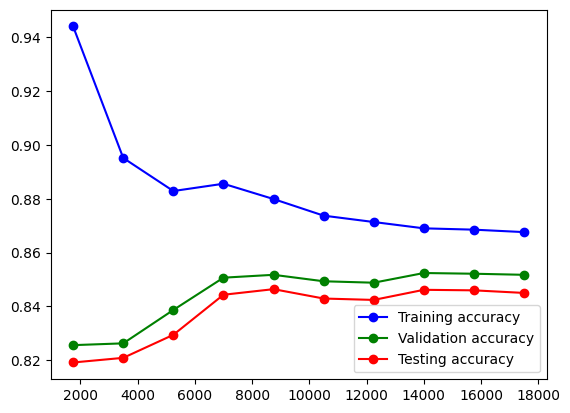

In [ ]:
from sklearn.metrics import accuracy_score
def custom_learning_curve(x_train, y_train,
                          x_val, y_val, x_test, y_test,
                          n_splits):

  split_size = int(len(x_train) / n_splits)
  x_splits = np.split(x_train, n_splits) # must be equal division
  y_splits = np.split(y_train, n_splits)
  train_accuracies = list()
  val_accuracies = list()
  test_accuracies = list()
  curr_x = x_splits[0]
  print(curr_x.shape)
  curr_y = y_splits[0]
  print(curr_y.shape)
  classifier = BernoulliNB(alpha = 1.0)
  classifier.fit(curr_x, curr_y)
  train_accuracies.append(accuracy_score(curr_y,
                                         classifier.predict(curr_x)))

  val_accuracies.append(accuracy_score(y_val, classifier.predict(x_val)))
  test_accuracies.append(accuracy_score(y_test, classifier.predict(x_test)))

  for i in range(1, len(x_splits)):
    classifier = BernoulliNB(alpha = 1.0)
    curr_x = np.concatenate((curr_x, x_splits[i]), axis=0)
    print(curr_x.shape)
    curr_y = np.concatenate((curr_y, y_splits[i]), axis=0)
    print(curr_y.shape)
    classifier.fit(curr_x, curr_y)

    train_accuracies.append(accuracy_score(curr_y,
                                           classifier.predict(curr_x)))

    val_accuracies.append(accuracy_score(y_val, classifier.predict(x_val)))

    test_accuracies.append(accuracy_score(y_test, classifier.predict(x_test)))

  plt.plot(list(range(split_size, len(x_train) + split_size,
                      split_size)), train_accuracies, 'o-', color="b",
             label="Training accuracy")
  plt.plot(list(range(split_size, len(x_train) + split_size,
                      split_size)), val_accuracies, 'o-', color="green",
           label="Validation accuracy")
  plt.plot(list(range(split_size, len(x_train) + split_size,
                      split_size)), test_accuracies, 'o-', color="red",
           label="Testing accuracy")
  plt.legend(loc="lower right")
  plt.show()

custom_learning_curve(x_train=x_trainbinary_copy , y_train=y_traincopy,
                      x_val=x_dev_binary, y_val=y_dev, x_test=x_test_binary,
                      y_test=y_test, n_splits=10)

# Logistic Regression with Stochastic Gradient Ascend + L2 regularization


Logistic Regression SGA with L2 regularization

In [24]:
class LogisticRegressionSGA_L2:
    def __init__(self, h = 0.1, lambda_ = 0.1 , repeats = 10):
      self.h = h
      self.repeats = repeats
      self.lambda_ = lambda_
      self.weights = None


    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, x_train, y_train):
      self.weights = np.zeros(len(x_train[0])) # Vector W (4000)
      for p in range(self.repeats):
        for i in range(len(x_train)): #25.000
          z = self.sigmoid(np.dot(x_train[i], self.weights)) # z1 = x1*w1 + x2*w2, + x3*w3 + ... + xn*wn
          gradient = (y_train[i] - z) * x_train[i] #typos gia gradient
          gradient = gradient - (self.lambda_ * self.weights) #typos gia gradient me L2 regul
          self.weights += self.h * gradient #typos gia gradient ascent me L2 regul



    def predict(self, x_train):
        y_predict = list()
        for x in x_train:
            z = self.sigmoid(np.dot(x, self.weights))
            if z >= 0.5:
              y_predict.append(1)
            else:
              y_predict.append(0)
        return y_predict



Classification Report

In [25]:
classifier = LogisticRegressionSGA_L2(0.0001, 0.1, 100)
classifier.fit(x_train_binary, y_train)
from sklearn.metrics import classification_report
print(classification_report(y_train, classifier.predict(x_train_binary)))
print(classification_report(y_test, classifier.predict(x_test_binary)))

              precision    recall  f1-score   support

           0       0.80      0.77      0.78     12500
           1       0.78      0.80      0.79     12500

    accuracy                           0.79     25000
   macro avg       0.79      0.79      0.79     25000
weighted avg       0.79      0.79      0.79     25000

              precision    recall  f1-score   support

           0       0.80      0.77      0.78     12500
           1       0.78      0.80      0.79     12500

    accuracy                           0.79     25000
   macro avg       0.79      0.79      0.79     25000
weighted avg       0.79      0.79      0.79     25000



Learning Curve

In [ ]:
from sklearn.metrics import accuracy_score
def custom_learning_curve(x_train, y_train,
                          x_val, y_val, x_test, y_test,
                          n_splits):

  split_size = int(len(x_train) / n_splits)
  x_splits = np.split(x_train, n_splits)
  y_splits = np.split(y_train, n_splits)
  train_accuracies = list()
  val_accuracies = list()
  test_accuracies = list()
  curr_x = x_splits[0]
  print(curr_x.shape)
  curr_y = y_splits[0]
  print(curr_y.shape)
  classifier =  LogisticRegressionSGA_L2(0.001, 0.1, 100)
  classifier.fit(curr_x, curr_y)
  train_accuracies.append(accuracy_score(curr_y,
                                         classifier.predict(curr_x)))

  val_accuracies.append(accuracy_score(y_val, classifier.predict(x_val)))
  test_accuracies.append(accuracy_score(y_test, classifier.predict(x_test)))

  for i in range(1, len(x_splits)):
    lsga =  LogisticRegressionSGA_L2(0.001, 0.1, 100)
    curr_x = np.concatenate((curr_x, x_splits[i]), axis=0)
    print(curr_x.shape)
    curr_y = np.concatenate((curr_y, y_splits[i]), axis=0)
    print(curr_y.shape)
    classifier.fit(curr_x, curr_y)

    train_accuracies.append(accuracy_score(curr_y,
                                           classifier.predict(curr_x)))

    val_accuracies.append(accuracy_score(y_val, classifier.predict(x_val)))

    test_accuracies.append(accuracy_score(y_test, classifier.predict(x_test)))

  plt.plot(list(range(split_size, len(x_train) + split_size,
                      split_size)), train_accuracies, 'o-', color="b",
             label="Training accuracy")
  plt.plot(list(range(split_size, len(x_train) + split_size,
                      split_size)), val_accuracies, 'o-', color="green",
           label="Validation accuracy")
  plt.plot(list(range(split_size, len(x_train) + split_size,
                      split_size)), test_accuracies, 'o-', color="red",
           label="Testing accuracy")
  plt.legend(loc="lower right")
  plt.show()

custom_learning_curve(x_train=x_trainbinary_copy , y_train=y_traincopy,
                      x_val=x_dev_binary, y_val=y_dev, x_test=x_test_binary,
                      y_test=y_test, n_splits=10)

# Logistic Regression Sklearn SGD with L2

Classification Report

In [ ]:
from sklearn.linear_model import SGDClassifier
classifier = SGDClassifier(loss='log_loss', learning_rate='constant', eta0=0.001,
                           alpha=0.1, max_iter=100)
classifier.fit(x_train_binary, y_train)
print(classification_report(y_train, classifier.predict(x_train_binary)))
print(classification_report(y_test, classifier.predict(x_test_binary)))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85     12500
           1       0.83      0.89      0.86     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000

              precision    recall  f1-score   support

           0       0.87      0.81      0.84     12500
           1       0.82      0.88      0.85     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



Learning Curve

(1750, 3801)
(1750,)
(3500, 3801)
(3500,)
(5250, 3801)
(5250,)
(7000, 3801)
(7000,)
(8750, 3801)
(8750,)
(10500, 3801)
(10500,)
(12250, 3801)
(12250,)
(14000, 3801)
(14000,)
(15750, 3801)
(15750,)
(17500, 3801)
(17500,)


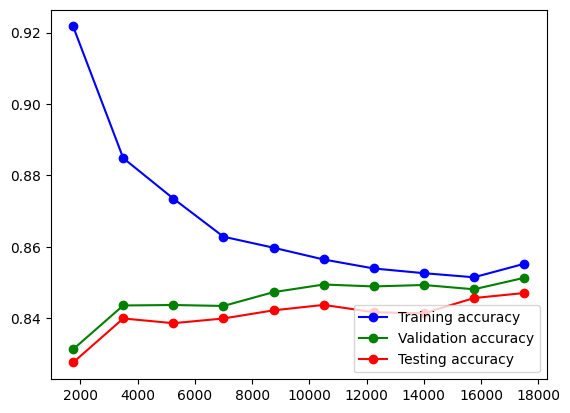

In [ ]:
from sklearn.metrics import accuracy_score
def custom_learning_curve(x_train, y_train,
                          x_val, y_val, x_test, y_test,
                          n_splits):

  split_size = int(len(x_train) / n_splits)
  x_splits = np.split(x_train, n_splits) # must be equal division
  y_splits = np.split(y_train, n_splits)
  train_accuracies = list()
  val_accuracies = list()
  test_accuracies = list()
  curr_x = x_splits[0]
  print(curr_x.shape)
  curr_y = y_splits[0]
  print(curr_y.shape)
  lsga = SGDClassifier(loss='log_loss', learning_rate='constant', eta0=0.001, alpha=0.1, max_iter=100)
  lsga.fit(curr_x, curr_y)
  train_accuracies.append(accuracy_score(curr_y,
                                         lsga.predict(curr_x)))

  val_accuracies.append(accuracy_score(y_val, lsga.predict(x_val)))
  test_accuracies.append(accuracy_score(y_test, lsga.predict(x_test)))

  for i in range(1, len(x_splits)):
    lsga = SGDClassifier(loss='log_loss', learning_rate='constant', eta0=0.001, alpha=0.1, max_iter=100)
    curr_x = np.concatenate((curr_x, x_splits[i]), axis=0)
    print(curr_x.shape)
    curr_y = np.concatenate((curr_y, y_splits[i]), axis=0)
    print(curr_y.shape)
    lsga.fit(curr_x, curr_y)

    train_accuracies.append(accuracy_score(curr_y,
                                           lsga.predict(curr_x)))

    val_accuracies.append(accuracy_score(y_val, lsga.predict(x_val)))

    test_accuracies.append(accuracy_score(y_test, lsga.predict(x_test)))

  plt.plot(list(range(split_size, len(x_train) + split_size,
                      split_size)), train_accuracies, 'o-', color="b",
             label="Training accuracy")
  plt.plot(list(range(split_size, len(x_train) + split_size,
                      split_size)), val_accuracies, 'o-', color="green",
           label="Validation accuracy")
  plt.plot(list(range(split_size, len(x_train) + split_size,
                      split_size)), test_accuracies, 'o-', color="red",
           label="Testing accuracy")
  plt.legend(loc="lower right")
  plt.show()

custom_learning_curve(x_train=x_trainbinary_copy , y_train=y_traincopy,
                      x_val=x_dev_binary, y_val=y_dev, x_test=x_test_binary,
                      y_test=y_test, n_splits=10)

# Data Preprocessing For RNN

In [4]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


tokenizer = Tokenizer(num_words=3801)
tokenizer.fit_on_texts(x_train)


x_train_curve, x_dev_curve, y_train_curve, y_dev_curve = train_test_split(x_train, y_train,
                                                                test_size=0.3)

x_train_sequences = tokenizer.texts_to_sequences(x_train)
x_test_sequences = tokenizer.texts_to_sequences(x_test)

x_train_curve_sequences = tokenizer.texts_to_sequences(x_train_curve)
x_dev_curve_sequences = tokenizer.texts_to_sequences(x_dev_curve)




In [ ]:
print(len(x_train_sequences))
print(len(x_train))

25000
25000


In [5]:
max_len = max(len(seq) for seq in x_train_sequences)
print("Maximum sequence length:", max_len)
max_len = max(len(seq) for seq in x_test_sequences)
print("Maximum sequence length:", max_len)

avg_len_train = sum(len(seq) > 200 for seq in x_train_sequences)
print("Average sequence length for training data:", avg_len_train)

avg_len_test = sum(len(seq) > 200 for seq in x_test_sequences)
print("Average sequence length for test data:", avg_len_test)

Maximum sequence length: 2494
Maximum sequence length: 2315
Average sequence length for training data: 10677
Average sequence length for test data: 10268


In [6]:
x_train = pad_sequences(x_train_sequences, maxlen=200)
x_test = pad_sequences(x_test_sequences, maxlen=200)
x_train_curve = pad_sequences(x_train_curve_sequences, maxlen=200)
x_dev_curve = pad_sequences(x_dev_curve_sequences, maxlen=200)

# Keras RNN with Word Embeddings

Model Compile

In [7]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image


imdb_rnn = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=3801, output_dim=30, input_length=200),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

imdb_rnn_copy = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=3801, output_dim=30, input_length=200),
    tf.keras.layers.LSTM(16, dropout = 0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

imdb_rnn.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['binary_accuracy'])

imdb_rnn_copy.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['binary_accuracy'])


Training, Evaluation and Classification Report

In [10]:
imdb_rnn.fit(x=x_train, y=y_train,epochs=10, verbose=1, batch_size=32)

print(imdb_rnn.evaluate(x_test, y_test))

782/782 [==============================] - 14s 17ms/step - loss: 0.4067 - binary_accuracy: 0.8382
[0.40666142106056213, 0.8381999731063843]


In [11]:
from sklearn.metrics import classification_report

y_pred_imdb = imdb_rnn.predict(x_test)

y_pred_imdb = (y_pred_imdb >= 0.5).astype(int)

print(classification_report(y_test, y_pred_imdb, zero_division=1))

782/782 [==============================] - 15s 17ms/step
[0.10328107]
              precision    recall  f1-score   support

           0       0.82      0.86      0.84     12500
           1       0.85      0.82      0.83     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



RNN Loss Plot

In [ ]:
imdb_rnn_history = imdb_rnn_copy.fit(x_train, y_train, batch_size=32,
                                  epochs=10, validation_split=0.3)

In [9]:
def plot(his, kind):
  train = his.history[kind]
  val = his.history['val_' + kind]
  epochs = range(1, len(train)+1)
  plt.figure(figsize=(12,9))
  plt.plot(epochs, train, 'b', label='Training ' + kind)
  plt.plot(epochs, val, 'orange', label='Validation ' + kind)
  plt.title('Training and validation ' + kind)
  plt.xlabel('Epochs')
  plt.ylabel(kind)
  # x1, x2, y1, y2 = plt.axis()
  # plt.axis((x1, x2, 0, 0.2))
  plt.legend()
  plt.show()

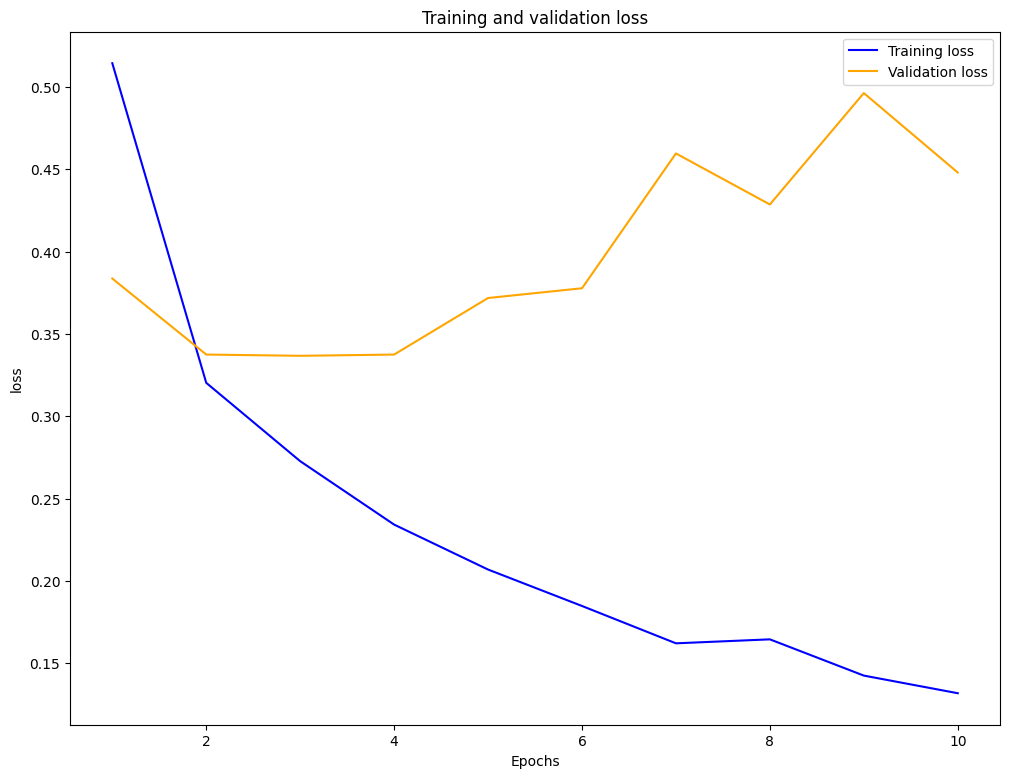

In [10]:
plot(imdb_rnn_history, 'loss')

Learning Curve

In [ ]:
from sklearn.metrics import accuracy_score
def custom_learning_curve(x_train, y_train,
                          x_val, y_val, x_test, y_test,
                          n_splits):

  split_size = int(len(x_train) / n_splits)
  x_splits = np.split(x_train, n_splits) # must be equal division
  y_splits = np.split(y_train, n_splits)
  train_accuracies = list()
  val_accuracies = list()
  test_accuracies = list()
  curr_x = x_splits[0]
  print(curr_x.shape)
  curr_y = y_splits[0]
  print(curr_y.shape)


  #y_pred_imdb = (y_pred_imdb >= 0.5).astype(int)

  classifier = imdb_rnn
  classifier.fit(x=curr_x, y=curr_y,epochs=5, verbose=1, batch_size=32)

  classifier_pred = classifier.predict(curr_x)
  classifier_pred = (classifier_pred >= 0.5).astype(int)

  train_accuracies.append(accuracy_score(curr_y, classifier_pred)) #classifier.predict(curr_x)

  classifier_pred = classifier.predict(x_val)
  classifier_pred = (classifier_pred >= 0.5).astype(int)

  val_accuracies.append(accuracy_score(y_val, classifier_pred)) #classifier.predict(x_val)

  classifier_pred = classifier.predict(x_test)
  classifier_pred = (classifier_pred >= 0.5).astype(int)

  test_accuracies.append(accuracy_score(y_test, classifier_pred)) #classifier.predict(x_test)

  for i in range(1, len(x_splits)):
    classifier = imdb_rnn
    curr_x = np.concatenate((curr_x, x_splits[i]), axis=0)
    print(curr_x.shape)
    curr_y = np.concatenate((curr_y, y_splits[i]), axis=0)
    print(curr_y.shape)
    classifier.fit(x=curr_x, y=curr_y,epochs=5, verbose=1, batch_size=32)

    classifier_pred = classifier.predict(curr_x)
    classifier_pred = (classifier_pred >= 0.5).astype(int)

    train_accuracies.append(accuracy_score(curr_y, classifier_pred))#classifier.predict(curr_x)

    classifier_pred = classifier.predict(x_val)
    classifier_pred = (classifier_pred >= 0.5).astype(int)

    val_accuracies.append(accuracy_score(y_val, classifier_pred))#classifier.predict(x_val)

    classifier_pred = classifier.predict(x_test)
    classifier_pred = (classifier_pred >= 0.5).astype(int)

    test_accuracies.append(accuracy_score(y_test, classifier_pred))#classifier.predict(x_test)

  plt.plot(list(range(split_size, len(x_train) + split_size,
                      split_size)), train_accuracies, 'o-', color="b",
             label="Training accuracy")
  plt.plot(list(range(split_size, len(x_train) + split_size,
                      split_size)), val_accuracies, 'o-', color="green",
           label="Validation accuracy")
  plt.plot(list(range(split_size, len(x_train) + split_size,
                      split_size)), test_accuracies, 'o-', color="red",
           label="Testing accuracy")
  plt.legend(loc="lower right")
  plt.show()

custom_learning_curve(x_train=x_train_curve, y_train=y_train_curve,
                      x_val=x_dev_curve, y_val=y_dev_curve, x_test=x_test,
                      y_test=y_test, n_splits=5)